In [1]:
try:
    import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
try:
    import tqdm
except ModuleNotFoundError:
    !pip install tqdm
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom

from fastkaggle import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.data.all import *
from tqdm.notebook import tqdm
import pydicom

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [2]:
comp = "rsna-pneumonia-detection-challenge"
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

## Classification

In [3]:
train_path = path/"stage_2_train_images"
bs = 64
epochs = 3
# arch = 'resnet26d'
arch = 'convnext_tiny_in22k'

In [4]:
labels = pd.read_csv(path/"stage_2_train_labels.csv")
labels = labels.drop_duplicates("patientId")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [5]:
def read_dicom_file(fpath):
    dcm = pydicom.read_file(fpath).pixel_array #/ 255
    # dcm = cv2.resize(dcm, (224, 224))#.astype(np.float16)
    img = Image.fromarray(dcm).convert("L")
    return img

In [6]:
def label_func(fname):
    return labels.loc[labels.patientId == fname.name[:-4], "Target"].values[0]

In [7]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_dicom_files,
                   get_x=read_dicom_file,
                   get_y=label_func,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(192),
                   batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [8]:
dls = dblock.dataloaders(train_path, bs=bs)

21348

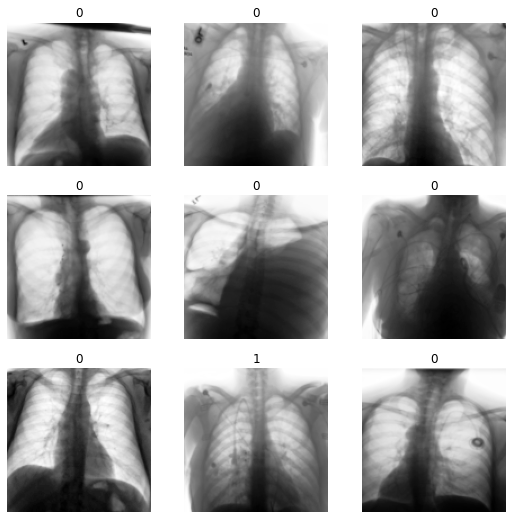

In [9]:
dls.show_batch()
len(dls.train_ds)

In [10]:
learn = vision_learner(dls, arch, metrics=error_rate, path='.').to_fp16()

/opt/conda/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


SuggestedLRs(valley=0.0020892962347716093, slide=0.00363078061491251)

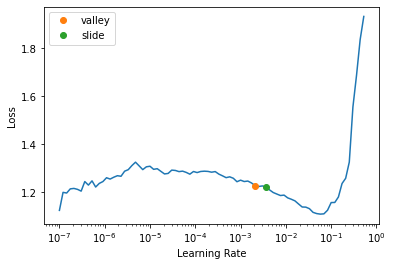

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
learn.fine_tune(epochs=epochs, base_lr=0.01)

In [13]:
learn.export('models/model.pkl')

In [14]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.1544)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4119
           1       0.73      0.51      0.60      1217

    accuracy                           0.85      5336
   macro avg       0.80      0.73      0.75      5336
weighted avg       0.84      0.85      0.84      5336



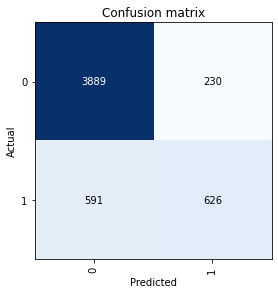

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

## Detection

## Submission

Write .csv in following format:

patientId,PredictionString  
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100  
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,  
00322d4d-1c29-4943-afc9-b6754be640eb,0.8 10 10 50 50 0.75 100 100 5 5

Sort file names

In [16]:
# import csv

# example data
data = [
    ['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '0.5 0 0 100 100'],
    ['00313ee0-9eaa-42f4-b0ab-c148ed3241cd', ''],
    ['00322d4d-1c29-4943-afc9-b6754be640eb', '0.8 10 10 50 50 0.75 100 100 5 5']
]

# write data to CSV file
with open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['patientId', 'PredictionString'])
    for row in data:
        writer.writerow(row)

sort file name

## CAM